### Estimate EEG Data without Artifcats

In [155]:
# %matplotlib inline

In [171]:
import mne
import numpy as np
from mne.datasets import sample
import matplotlib.pyplot as plt
import h5py

#### Load Forward Model

In [172]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
info = mne.io.read_info(raw_fname) 
fwd = mne.read_forward_solution("sample_forward_model")

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from sample_forward_model...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


<ipython-input-172-4a7190ffba04>:4: RuntimeWarning: This filename (sample_forward_model) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("sample_forward_model")


In [173]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


In [174]:
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 60 sensors x 7498 dipoles


In [175]:
n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
# stc = mne.SourceEstimate(1e-9 * np.eye(n_dipoles), vertices, tmin=0., tstep=1)
# leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9

#### Use Forward Model to Estimate Data

In [176]:
n_sensors = 60
n_times = 36000
time_step = 0.08
frequency = 20
channel_names = [str(i) for i in range(60)]

Random source

In [177]:
z = np.dot(np.random.randn(n_dipoles, n_sensors), np.random.randn(n_sensors, n_times)) #* 1e-9

In [178]:
# n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
# z = np.random.randn(n_dipoles, n_dipoles) * 1e-9
stc = mne.SourceEstimate(z, vertices, tmin=0., tstep=time_step)
leadfield = mne.apply_forward(fwd_fixed, stc, info).data# / np.sum(z, axis=1)

Projecting source estimate to sensor space...


<ipython-input-178-58fecc88349d>:5: RuntimeWarning: The maximum current magnitude is 51563030927.6 nAm, which is very large. Are you trying to apply the forward model to noise-normalized (dSPM, sLORETA, or eLORETA) values? The result will only be correct if currents (in units of Am) are used.
  leadfield = mne.apply_forward(fwd_fixed, stc, info).data# / np.sum(z, axis=1)


[done]


In [115]:
leadfield.shape

(60, 36000)

In [116]:
leadfield = mne.apply_forward(fwd_fixed, stc, info)

Projecting source estimate to sensor space...
[done]


### Save Data to .fif

In [179]:
filename = "test_raw.fif"

In [180]:
data = leadfield.data
info = mne.create_info(channel_names, frequency, 
                       "eeg")#, montage='standard_1020')

In [181]:
customraw = mne.io.RawArray(data, info)
customraw.save(filename, overwrite=True)

Creating RawArray with float64 data, n_channels=60, n_times=36000
    Range : 0 ... 35999 =      0.000 ...  1799.950 secs
Ready.
Overwriting existing file.
Writing /Users/DanielLongo/Desktop/eegML/forward_model/test_raw.fif
Closing /Users/DanielLongo/Desktop/eegML/forward_model/test_raw.fif [done]


### Load Data

In [182]:
plt.ion()

In [183]:
x = mne.io.read_raw_fif(filename)

Opening raw data file /Users/DanielLongo/Desktop/eegML/forward_model/test_raw.fif...
Isotrak not found
    Range : 0 ... 35999 =      0.000 ...  1799.950 secs
Ready.


In [184]:
raw = x

In [ ]:
order = np.arange(raw.info['nchan'])
order[9] = 59  # We exchange the plotting order of two channels
order[59] = 9  # to show the trigger channel as the 10th channel.
raw.plot(n_channels=60, block=False)

In [ ]:
mne.Epochs()

### To Visualize

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

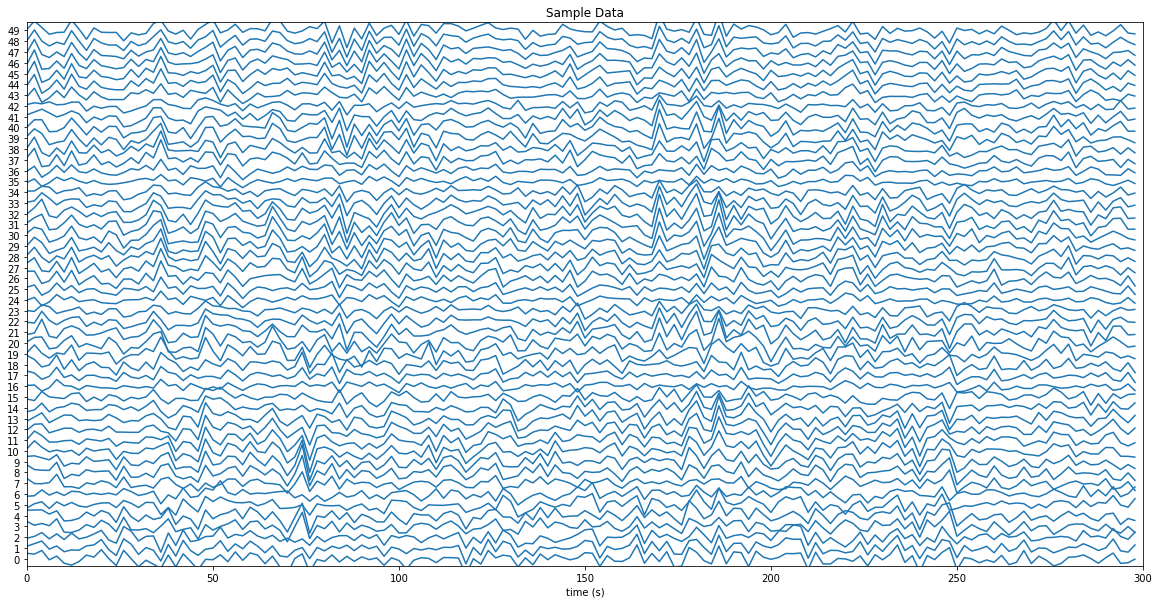

In [131]:
stacklineplot.show_epoch_centered(x, 100, epoch_width_sec=400, chstart=0, chstop=50, fs=frequency, ylabels=channel_names, yscale=3.0)
plt.title('Sample Data');

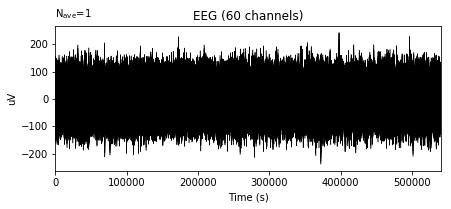

In [16]:
fig = leadfield.plot(exclude=(), time_unit='s')

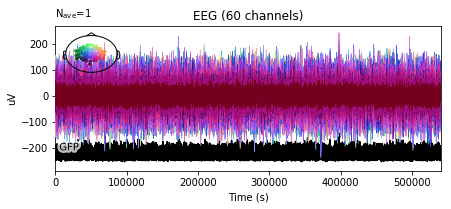

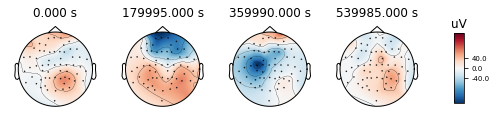

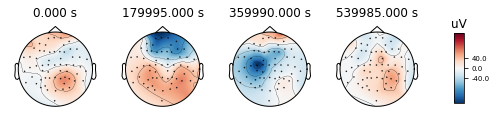

In [17]:
picks = mne.pick_types(leadfield.info, meg=False, eeg=True, eog=False)
leadfield.plot(spatial_colors=True, gfp=True, picks=picks, time_unit='s')
leadfield.plot_topomap(time_unit='s')

### Old

In [18]:
import stacklineplot 

In [25]:
f = h5py.File('mytestfile.hdf5', 'r+')

In [30]:
h5f = h5py.File('test.h5', 'r+')
h5f.create_dataset('test', data=leadfield.data)
# h5f.close()
h5f = h5py.File('test.h5','r')
type(h5f['test'][:])

RuntimeError: Unable to create link (Name already exists)

In [26]:
f.create_dataset("generated_data_c", data=leadfield.data)

<HDF5 dataset "generated_data_c": shape (60, 36000), type "<f8">

In [46]:
dset =  h5py.Group.create_dataset(name="generated_data", data=leadfield.data)

TypeError: create_dataset() missing 1 required positional argument: 'self'

In [28]:
x = f["generated_data_c"]